# Inaugural Project

Imports and set magics:

In [1]:
#Import packages
import numpy as np
import warnings

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

#Ignore warning
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Import your own code
from CouplesModel import CouplesModel

# Question 1

The model is specified in a class called CouplesClass. The class includes all model equations as well as methods for solving and simulating the model.

I create an instance of the model:

In [2]:
model = CouplesModel()

To solve the model using a discrete grid, I call the solve_discrete method. The procedure goes like this:
- Calculate the value of choice for all possible choices
- Check if the conditions aren't violated, else set value to negative infinity
- Find the maximum value, and corresponding choices

In [3]:
model.solve_discrete()

I know calculate HF/HM for different sets of parameters and make a table

In [4]:
#a. Setup for table
alpha = [0.25,0.5,0.75] #alpha grid
sigma = [0.5,1.0,1.5] #sigma grid

#b. Make table
#i. Print title and line seperator
title = 'Table 1: Relative labor in home production, HF/HM'
print(title)
print('-'*50) #line seperator

#ii. Print header and line seperator
header = rf"alpha \ sigma|{sigma[0]:10.2}{sigma[1]:10.2f}{sigma[2]:10.2f}     "
print(header)
print(f"{'-'*len(header[:header.index('|')])}+{'-'*len(header[header.index('|'):])}") #line seperator

#iii. Print main table
for a in alpha:
    #o. Print index with alpha values
    row = f"{a:9.2f}    |"
    
    #oo. Add output to string one-by-one through loop
    for s in sigma:
        #1. Set up and solve model based on alpha and sigma values
        temp = CouplesModel(**{'alpha':a,'sigma':s})
        temp.solve_discrete()
        
        #2. Calculate output
        out = temp.sol_disc.HF / temp.sol_disc.HM
        
        #3. Add output to string
        row += f"{out:10.2f}"
    
    #ooo. Print string
    print(row)
print('-'*50)
        

Table 1: Relative labor in home production, HF/HM
--------------------------------------------------
alpha \ sigma|       0.5      1.00      1.50     
-------------+------------------------------------
     0.25    |      0.55      0.31      0.21
     0.50    |      1.00      1.00      1.00
     0.75    |      1.83      3.25      4.67
--------------------------------------------------


## Question 2

I calculate log(HF/HM) for different wF values using the method solve_wF_vec

In [5]:
model.solve_wF_vec(discrete=True)

I plot log(HF/HM) against log(wF/wM) using the method plot

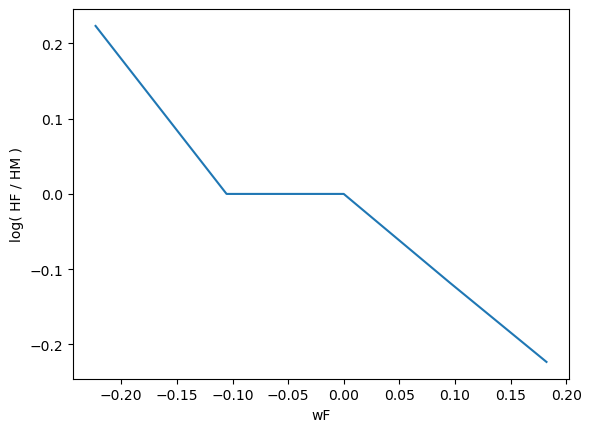

In [6]:
model.plot(discrete=True)

It seems like there is no difference in the relative time spend on home production for wF=-0.10 and wF=0.00. I believe this is a result of solving the model with a discrete grid. The optimal HF and HM happens to be the same in the two cases, but only because the agents can't perfectly choose any HF and HM they want to.

## Question 3

I solve the model with a continuous choice set using the method solve_continuous. I use the solver 'B-BFGS-H' and the discrete solution as an initial guess. 

In [7]:
model.solve_continuous()
model.sol_cont

namespace(LM=4.454523225032927,
          LF=4.454064251994442,
          HM=4.454911194897205,
          HF=4.454515445595485,
          V=-0.2381101582308815)

I calculate log(HF/HM) for different wF values using the method solve_wF_vec

In [8]:
model.solve_wF_vec()

I plot log(HF/HM) against log(wF/wM) using the method plot

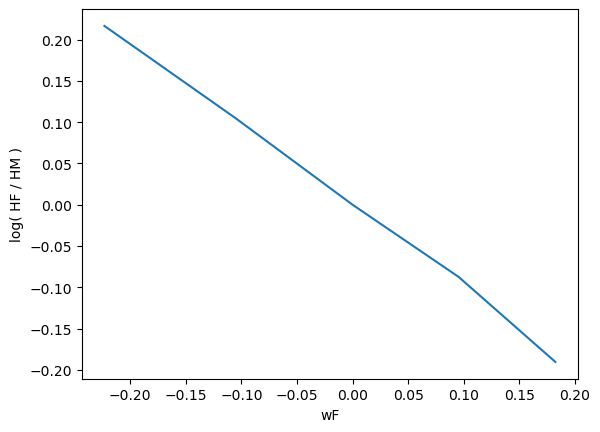

In [9]:
model.plot()

This shows that the relative time spent on domestic work changes with wF. This suggests that the discrete grid used in question 2 was too sparse and couldn't propperly capture the dynamics.

## Question 4

To find an $\alpha$ and $\sigma$ that minimizes $(\beta_0-\hat{\beta}_0)^2+(\beta_1-\hat{\beta}_1)^2$ I use a Simulated Minimum Distance estimator (SMD). The idea is to simulate the moments ($\hat{\beta}_0$,$\hat{\beta}_1$) using the model, and find the minimum distance to the moments in the data ($\beta_0$, $\beta_1$), then update the parameters and try again until convergence. The procedure goes like this:
1. Set initial $\alpha$, $\sigma$
2. Calculate $\hat{\beta}_0$,$\hat{\beta}_1$
3. Evaluate squared distance in moments, $(\beta_0-\hat{\beta}_0)^2+(\beta_1-\hat{\beta}_1)^2$
4. If distance is 0, or there is convergence, then terminate; else update $\alpha$, $\sigma$ and return to step 2.

I have nested this procedure in the method SMD. Here I apply a solver (Nelder-Mead) to evaluate the objective function (the squared moments) given by the method SMD_obj. For each guess the parameters are updated, the model is solved again, and $\hat{\beta}_0$,$\hat{\beta}_1$ are calculated using the method simulate_moments. Notice that simulate_moments calls the method estimate_beta to calculate $\hat{\beta}_0$,$\hat{\beta}_1$.

In [10]:
#Setup
guess = (0.5,1.) #initial guess on parameters
pnames = ('alpha', 'sigma') #parameter names - these will be estimated
beta_data = (0.4,-0.1) #data for beta (target to match)
bounds = ((0.0001,0.9999),(0.001,np.inf)) #bounds for parameters

#Estimate
res = model.SMD(guess,pnames,beta_data,bounds)

Iteration:   1,   Guess: ['0.5000', '1.0000'],   Objective function:  0.95791954,   LF_vec: ['2.90', '3.74', '4.45', '4.96', '5.52']
Iteration:   2,   Guess: ['0.5250', '1.0000'],   Objective function:  0.95589921,   LF_vec: ['2.58', '3.46', '4.23', '4.89', '5.28']
Iteration:   3,   Guess: ['0.5000', '1.0500'],   Objective function:  1.02827877,   LF_vec: ['2.89', '3.73', '4.45', '4.97', '5.54']
Iteration:   4,   Guess: ['0.5250', '0.9500'],   Objective function:  0.87881321,   LF_vec: ['2.59', '3.47', '4.24', '4.89', '5.27']
Iteration:   5,   Guess: ['0.5375', '0.9000'],   Objective function:  0.70338774,   LF_vec: ['2.58', '3.45', '4.15', '4.71', '5.13']
Iteration:   6,   Guess: ['0.5625', '0.9000'],   Objective function:  0.65545093,   LF_vec: ['2.35', '3.23', '3.95', '4.48', '4.99']
Iteration:   7,   Guess: ['0.5938', '0.8500'],   Objective function:  0.64732584,   LF_vec: ['2.09', '2.96', '3.73', '4.35', '4.81']
Iteration:   8,   Guess: ['0.6062', '0.7500'],   Objective function: 

Check solver status

In [11]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6.228029173928389e-16
             x: [ 9.819e-01  1.002e-01]
           nit: 70
          nfev: 145
 final_simplex: (array([[ 9.819e-01,  1.002e-01],
                       [ 9.819e-01,  1.002e-01],
                       [ 9.819e-01,  1.002e-01]]), array([ 6.228e-16,  8.561e-14,  1.774e-13]))

Check beta estimates from model

In [12]:
model.updatepar(pnames,res.x)
model.solve_wF_vec()
model.estimate_beta()

array([ 0.40000002, -0.10000001])

I fit the data with paramter estimates of $\alpha=0.98, \sigma=0.10$. The interpretation would be that female labor in house production is much more productive. Male and female labor is complementary, so the male part also provides some labor.

## Question 5

I extend the model by including a measure of relative income in the utility function. The interpretation is that the household prefers that one spouse has a higher income. This can be to fit into social gender norms. The utility function then becomes
$$
\frac{Q^{1-\rho}}{1-\rho} - \nu \left( \frac{T_M^{1 + \frac{1}{\epsilon}}} {1 + \frac{1}{\epsilon}} + \frac{T_F^{1 + \frac{1}{\epsilon}}} {1 + \frac{1}{\epsilon}} \right) + \xi \frac{(\frac{w_M L_M}{w_F L_F})^{1-\eta}}{1-\eta}
$$

I set $\alpha=0.5$ and estimate $\xi, \eta, \sigma$.

In [14]:
model.par.alpha=0.5
guess = (0.0,1.0,res.x[1])
pnames = ('xi','eta','sigma')
beta_data = (0.4,-0.1)
bounds = ((-np.inf,np.inf),(0.001,np.inf),(0.001,np.inf))
res = model.SMD(guess,pnames,beta_data,bounds, tol=1e-06)

Iteration:   1,   Guess: ['0.0000', '1.0000', '0.1002'],   Objective function:  0.16014868,   LF_vec: ['3.42', '3.98', '4.45', '4.89', '5.13']
Iteration:   2,   Guess: ['0.0003', '1.0000', '0.1002'],   Objective function:  0.15931835,   LF_vec: ['3.35', '3.96', '4.44', '4.75', '5.10']
Iteration:   3,   Guess: ['0.0000', '1.0500', '0.1002'],   Objective function:  0.16014868,   LF_vec: ['3.42', '3.98', '4.45', '4.89', '5.13']
Iteration:   4,   Guess: ['0.0000', '1.0000', '0.1052'],   Objective function:  0.16017843,   LF_vec: ['3.41', '3.98', '4.45', '4.89', '5.14']
Iteration:   5,   Guess: ['0.0002', '1.0333', '0.0952'],   Objective function:  0.15956118,   LF_vec: ['3.38', '3.97', '4.45', '4.76', '5.11']
Iteration:   6,   Guess: ['0.0003', '0.9722', '0.0969'],   Objective function:  0.15917456,   LF_vec: ['3.32', '3.96', '4.44', '4.75', '5.09']
Iteration:   7,   Guess: ['0.0004', '0.9333', '0.0952'],   Objective function:  0.16274446,   LF_vec: ['0.00', '3.87', '4.35', '4.72', '5.08']

Check solver status

In [15]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.056521528083685345
             x: [ 2.344e-02  5.205e+00  1.050e+00]
           nit: 202
          nfev: 477
 final_simplex: (array([[ 2.344e-02,  5.205e+00,  1.050e+00],
                       [ 2.344e-02,  5.205e+00,  1.050e+00],
                       [ 2.344e-02,  5.205e+00,  1.050e+00],
                       [ 2.344e-02,  5.205e+00,  1.050e+00]]), array([ 5.652e-02,  5.652e-02,  5.652e-02,  5.652e-02]))

Check beta estimate

In [16]:
model.updatepar(pnames,res.x)
model.solve_wF_vec()
model.estimate_beta()

array([ 0.18551683, -0.20255973])

I can't perfectly match the data with this extension, but I come somewhat close. I estimate $\xi=0.023, \eta=5.20, \sigma=1.05$. This suggests that the household prefers that one spouse has a higher income. It is interesting that $\sigma$ becomes greater than 1. This suggests that labor in home production is relatively substitutable, which I find more intuitive than the results from question 4. 